# Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Предстоит модель для такого предсказания.

Примечания:

Значение метрики RMSE на тестовой выборке должно быть не больше 48.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from phik import phik_matrix
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.model_selection import train_test_split
from sklearn.base import (
    TransformerMixin,
    BaseEstimator
)
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import root_mean_squared_error
import time

from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

RANDOM_STATE=42

import warnings
warnings.filterwarnings('ignore')

# Загрузка данных

In [2]:
try:
    taxi = pd.read_csv('taxi.csv', index_col='datetime', parse_dates=True)
except:
    taxi = pd.read_csv('/datasets/taxi.csv', index_col='datetime', parse_dates=True)

In [3]:
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


# Предобработка данных

Индексы нужно отсортировать и по условию ресэмплировать по одному часу. 

In [5]:
df = taxi.sort_index()
df = df.resample('1H').sum()

df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Проверим, что индексы уникальны и в них нет пропусков.

In [6]:
if df.index.is_unique and df.index.is_monotonic_increasing:
    print("Индекс уникален и упорядочен.")
else:
    print("Индекс не уникален или не упорядочен.")

Индекс уникален и упорядочен.


Еще нужно проверить, что в датах нет пропусков.

In [7]:
full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')

missing_dates = full_range.difference(df.index)

if missing_dates.empty:
    print("Пропущенных дней нет.")
else:
    print("Пропущенные дни:")
    print(missing_dates)

Пропущенных дней нет.


Данные успешно загружены и предобработны. Пропущенные дни отсутсвуют. С данными всё в порядке, их можно использовать для исследования.

# Исследовательский анализ данных

Посмотрим за какой период у нас имеются данные.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: h
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 198.0 KB


In [9]:
print('Минимальная дата:', df.index.min())
print('Максимальная дата:', df.index.max())

Минимальная дата: 2018-03-01 00:00:00
Максимальная дата: 2018-08-31 23:00:00


Как видим, у нас данные с марта по август 2018 года. Посмотрим графики.

Text(0, 0.5, 'Количество заказов')

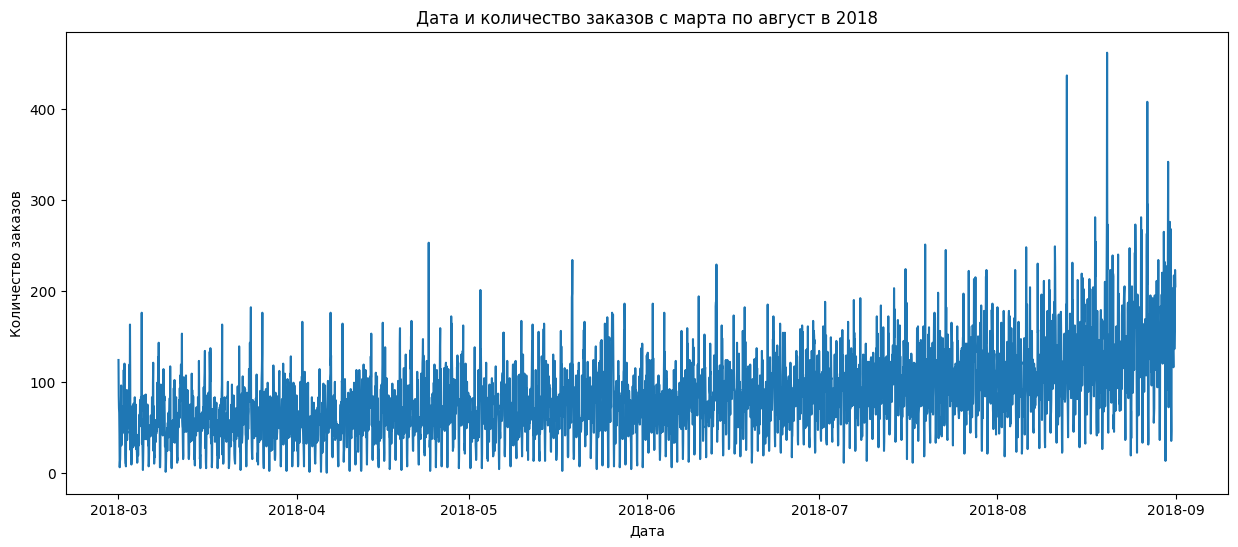

In [10]:
plt.figure(figsize = (15,6))
plt.plot(df)
plt.title('Дата и количество заказов с марта по август в 2018')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')

Построим графики скользящих среднего и стандартного отклонения.

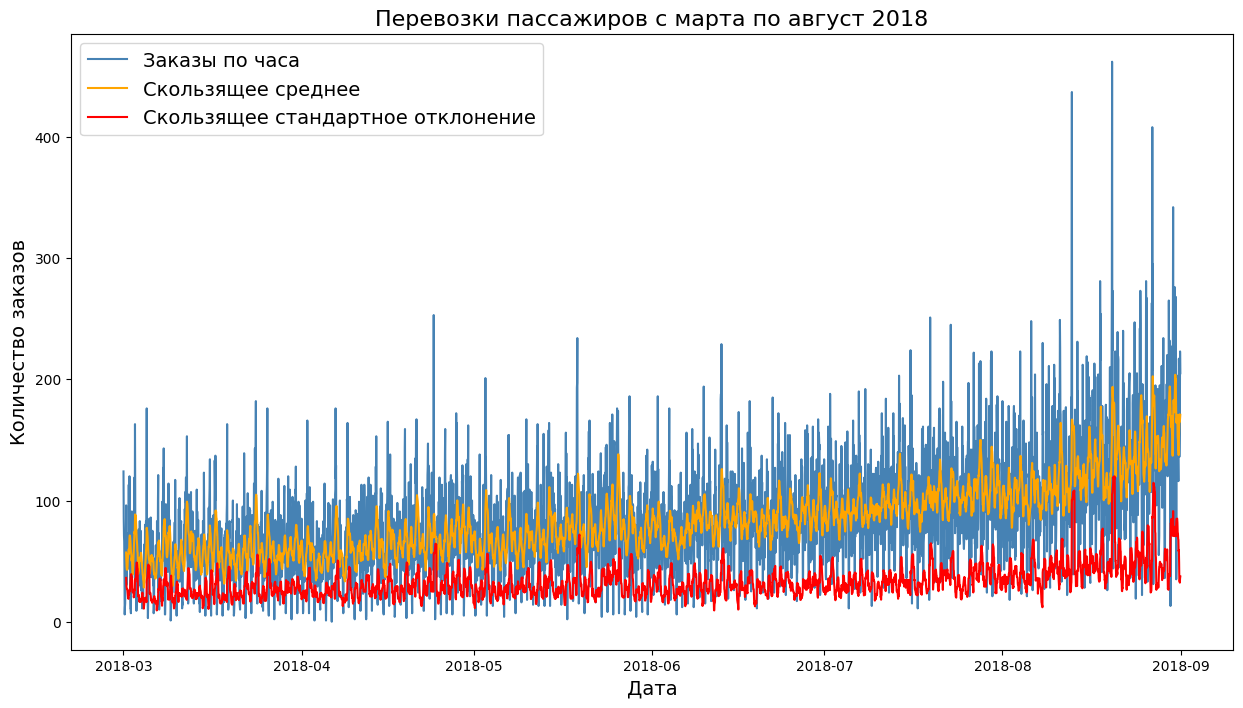

In [11]:
plt.figure(figsize = (15,8))

plt.plot(df, label = 'Заказы по часа', color = 'steelblue')
plt.plot(df.rolling(window = 12).mean(), label = 'Скользящее среднее', color = 'orange')

plt.plot(df.rolling(window = 12).std(), label = 'Скользящее стандартное отклонение', color = 'red')

plt.legend(title = '', loc = 'upper left', fontsize = 14)

plt.xlabel('Дата', fontsize = 14)
plt.ylabel('Количество заказов', fontsize = 14)
plt.title('Перевозки пассажиров с марта по август 2018', fontsize = 16)

plt.show()

Разложим ряд на компоненты.

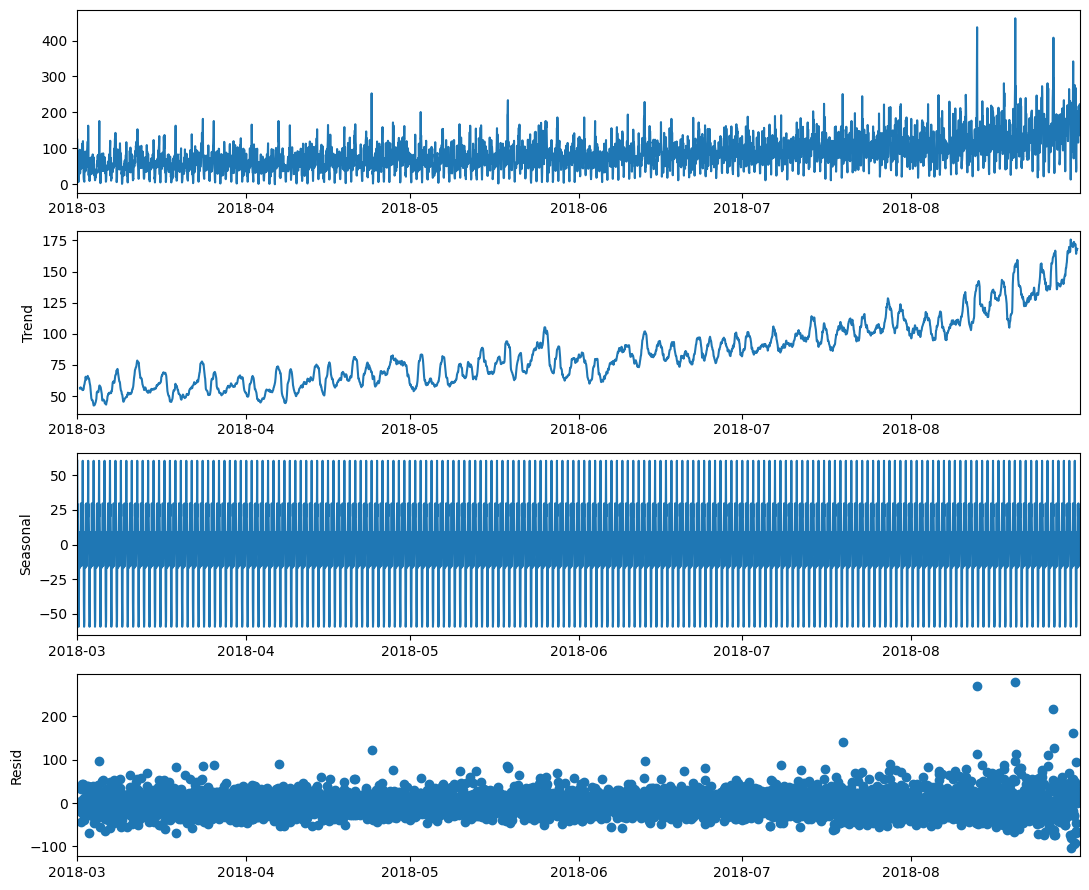

In [12]:
rcParams['figure.figsize'] = 11, 9

decompose = seasonal_decompose(df)
decompose.plot()

plt.show()

Видим увеличивающийся тренд популярности такси. А по сезонности построим еще один график по дням в течение трех разных недель.

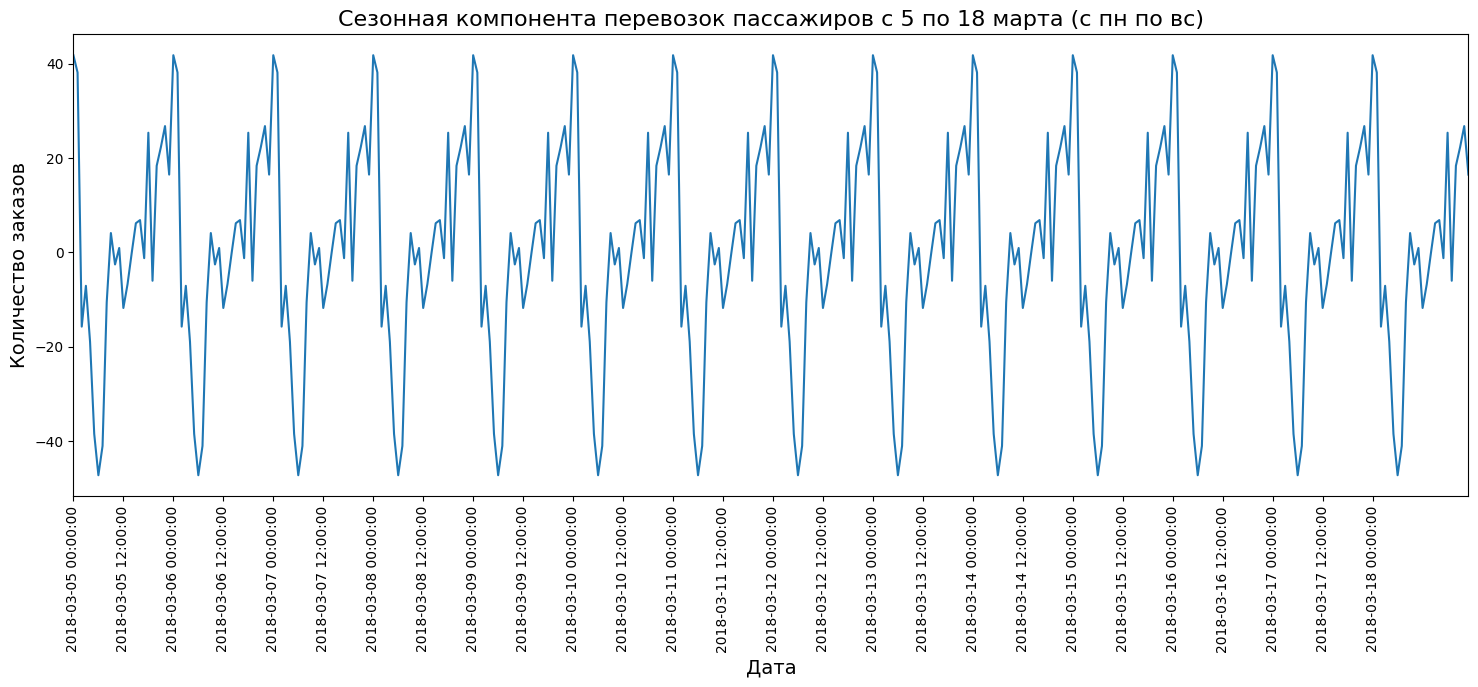

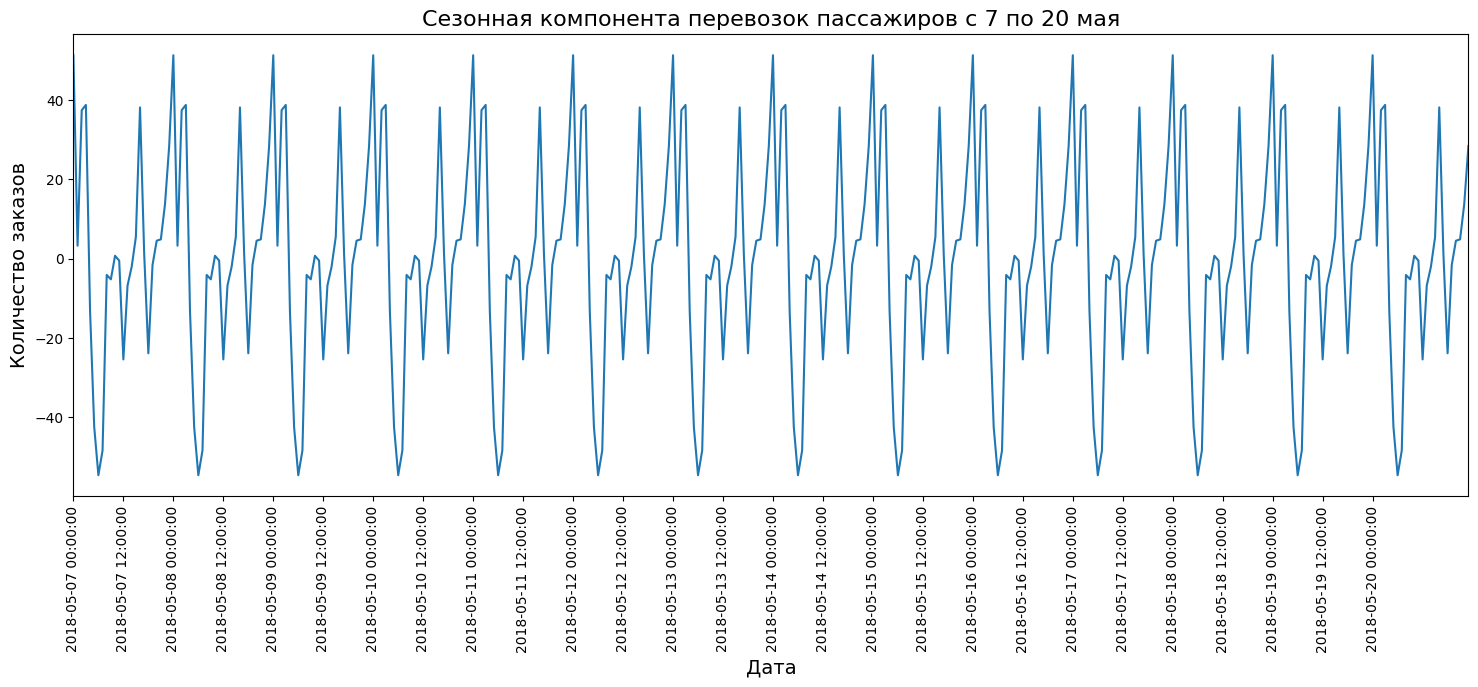

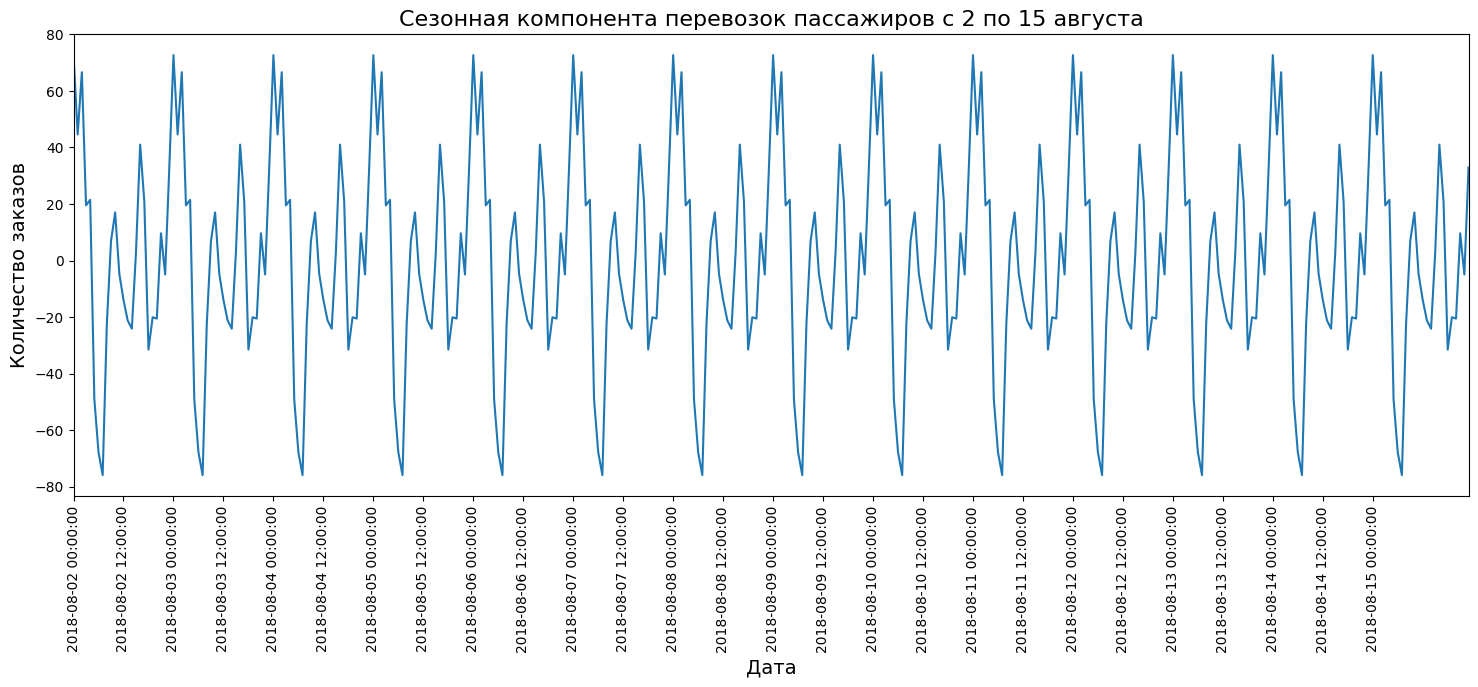

In [13]:
decompose = seasonal_decompose(df['2018-03-05':'2018-03-18'])
seasonal = decompose.seasonal
fig, ax = plt.subplots(figsize=(18,6))
seasonal.plot(ax=ax)

date_range = pd.date_range(start='2018-03-05', end='2018-03-18', freq='12H')
ax.set_xticks(date_range)
ax.set_xticklabels(date_range, rotation=90)
plt.xlabel('Дата', fontsize = 14)
plt.ylabel('Количество заказов', fontsize = 14)
plt.title('Сезонная компонента перевозок пассажиров с 5 по 18 марта (с пн по вс)', fontsize = 16)
plt.show()

decompose1 = seasonal_decompose(df['2018-05-07':'2018-05-20'])
seasonal1 = decompose1.seasonal

fig, ax1 = plt.subplots(figsize=(18, 6))
seasonal1.plot(ax=ax1)

date_range1 = pd.date_range(start='2018-05-07', end='2018-05-20', freq='12H')
ax1.set_xticks(date_range1)
ax1.set_xticklabels(date_range1, rotation=90)
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Количество заказов', fontsize=14)
plt.title('Сезонная компонента перевозок пассажиров с 7 по 20 мая', fontsize=16)
plt.show()

# Второй временной интервал: с 2 по 15 августа
decompose2 = seasonal_decompose(df['2018-08-02':'2018-08-15'])
seasonal2 = decompose2.seasonal

fig, ax2 = plt.subplots(figsize=(18, 6))
seasonal2.plot(ax=ax2)

date_range2 = pd.date_range(start='2018-08-02', end='2018-08-15', freq='12H')
ax2.set_xticks(date_range2)
ax2.set_xticklabels(date_range2, rotation=90)
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Количество заказов', fontsize=14)
plt.title('Сезонная компонента перевозок пассажиров с 2 по 15 августа', fontsize=16)
plt.show()


В графике сезонности видно, что к полуночи количество заказов начинает расти, а к утру уменьшаться. Посмотрим сезонность по дням недели.

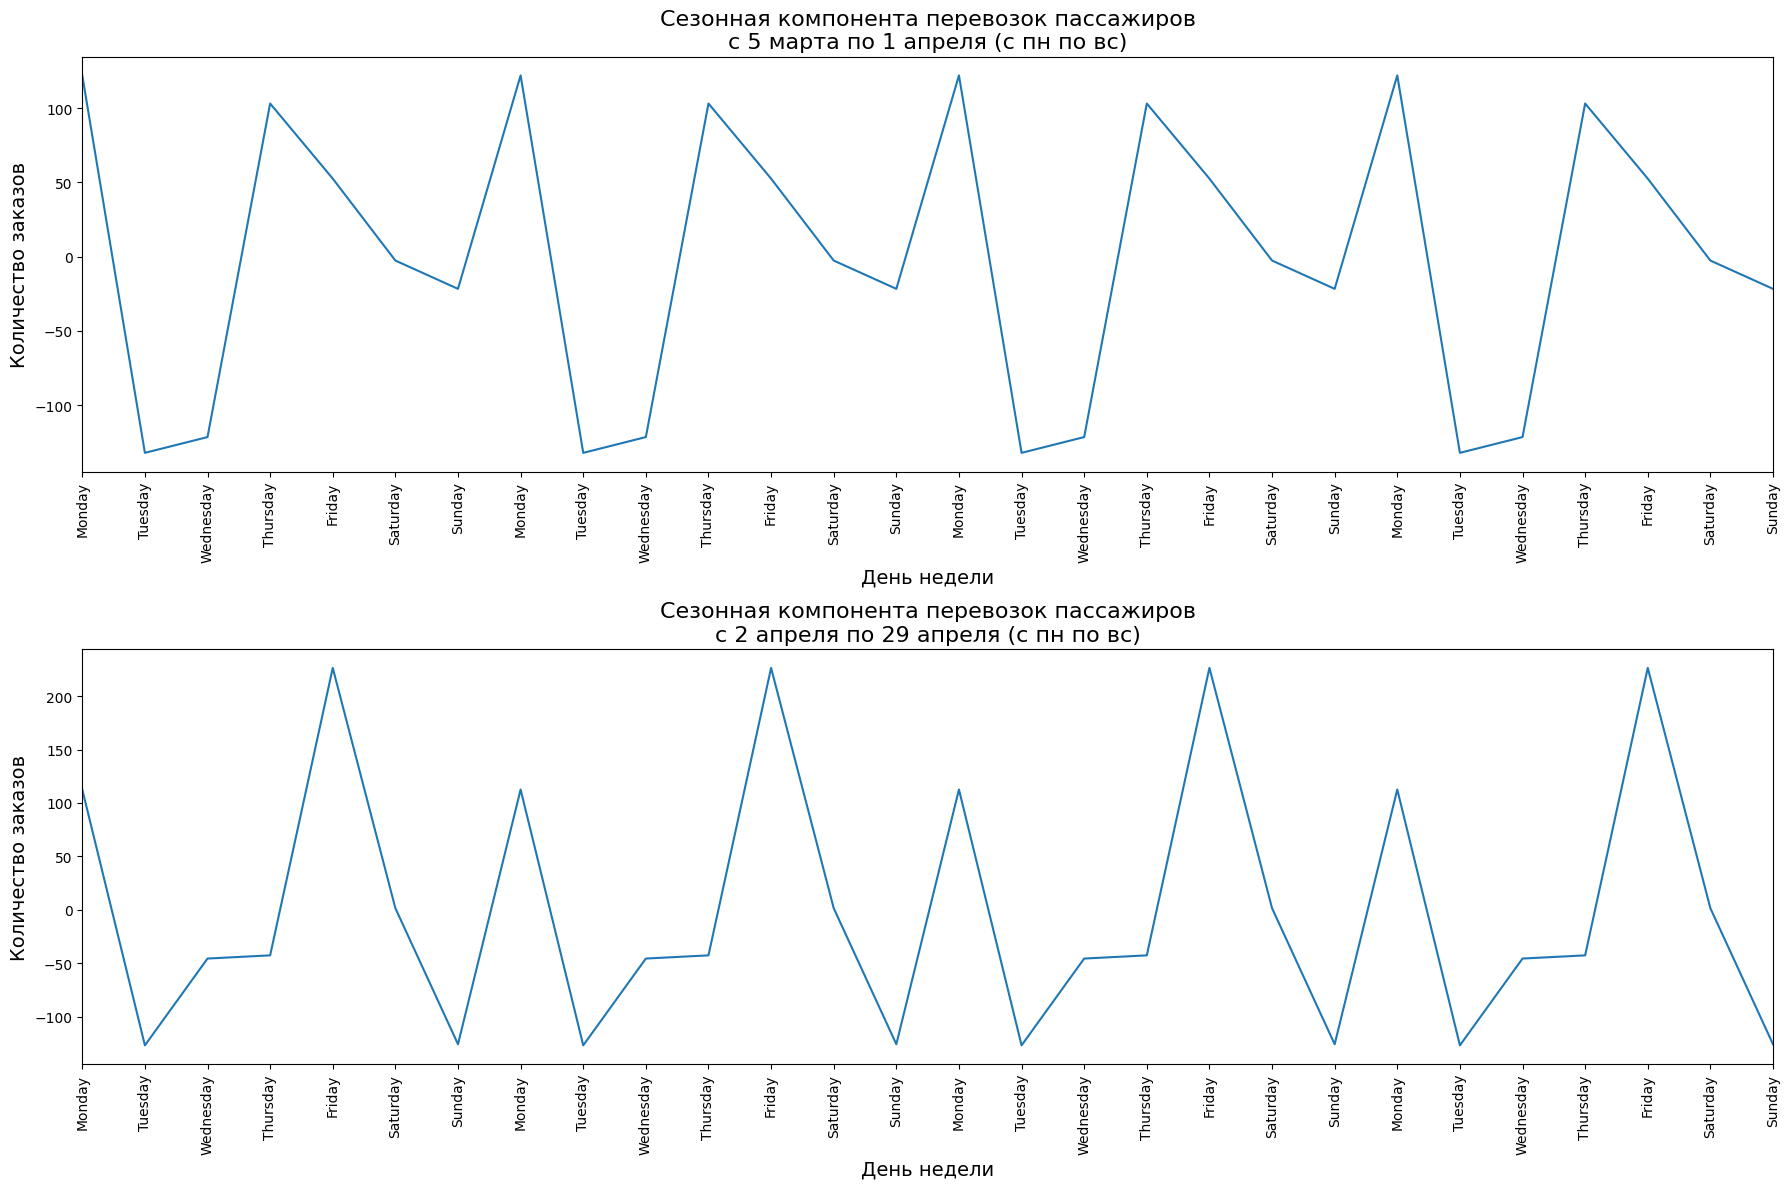

In [14]:
# Пример для первого периода (с 5 марта по 1 апреля)

df_daily_compose = df.resample('1D').sum()
decompose_daily1 = seasonal_decompose(df_daily_compose['2018-03-05':'2018-04-01'])
seasonal_daily1 = decompose_daily1.seasonal

# Пример для второго периода (с 2 апреля по 29 апреля)
decompose_daily2 = seasonal_decompose(df_daily_compose['2018-04-02':'2018-04-29'])
seasonal_daily2 = decompose_daily2.seasonal

# Создаем фигуру с двумя подграфиками
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 12))

# Первый подграфик (первый период)
seasonal_daily1.plot(ax=ax1)
date_range1 = pd.date_range(start='2018-03-05', end='2018-04-01', freq='1D')
days_of_week1 = date_range1.strftime('%A')
ax1.set_xticks(date_range1)
ax1.set_xticklabels(days_of_week1, rotation=90)
ax1.set_xlabel('День недели', fontsize=14)
ax1.set_ylabel('Количество заказов', fontsize=14)
ax1.set_title('Сезонная компонента перевозок пассажиров\nс 5 марта по 1 апреля (с пн по вс)', fontsize=16)

# Второй подграфик (второй период)
seasonal_daily2.plot(ax=ax2)
date_range2 = pd.date_range(start='2018-04-02', end='2018-04-29', freq='1D')
days_of_week2 = date_range2.strftime('%A')
ax2.set_xticks(date_range2)
ax2.set_xticklabels(days_of_week2, rotation=90)
ax2.set_xlabel('День недели', fontsize=14)
ax2.set_ylabel('Количество заказов', fontsize=14)
ax2.set_title('Сезонная компонента перевозок пассажиров\nс 2 апреля по 29 апреля (с пн по вс)', fontsize=16)

# Размещение подграфиков
plt.tight_layout()
plt.show()


В марте 2018 количество заказов увеличивалось по понедельникам и четвергам, а в апреле 2018 сезонная компонента совсем другая, поэтому не стоит ориентироваться на данные прошлого месяца по дням увеличения заказов. 

Проверим ряд на стационарность. Будем использовать тест Дики-Фуллера. Порогом возьмём 0.01.

- Нулевая гипотеза предполагает, что процесс нестационарный- 
Альтернативная гипотеза соответственно говорит об обратном

In [15]:
adf_test = adfuller(df['num_orders'])

if adf_test[1] < 0.01:
    print('Ряд стационарен')
else:
    print('Не отвергаем нулевую гипотезу')

print('p-value = ' +str(adf_test[1]))

Не отвергаем нулевую гипотезу
p-value = 0.0289400514026128


Значение очень мало, но всё же больше, чем 0.01 и мы видели слабый, но возрастающий тренд и возрастающее среднее, поэтому не можем считать, что наш ряд стационарен.

## Вывод

В рамках проведенного исследовательского анализа данных были выполнены различные этапы для изучения динамики спроса на такси. Основными инструментами анализа стали построение графиков скользящего среднего и стандартного отклонения, а также графиков тренда, сезонности и шума.

Графики скользящего среднего и стандартного отклонения позволили оценить средний уровень спроса на такси в течение времени и его изменчивость.

По результатам анализа был выявлен явный тренд на рост спроса с марта по август. Это может указывать на сезонные изменения или общий рост интереса к услугам такси в теплые месяцы. Графики тренда, сезонности и шума подтвердили наличие пиковой активности спроса в ночное время. В частности, изучение сезонности показало, что спрос на такси увеличивается к полуночи и затем постепенно снижается. Это может быть связано с пиковыми часами активности вечером и ночью, когда люди возвращаются домой после работы или отдыхают в городе.

Однако не были выявлены четкие закономерности в изменении спроса по дням недели. Каждый месяц показал различные дни, когда начинается рост спроса.

Таким образом, исследовательский анализ данных позволил более глубоко понять динамику спроса на такси, выявив сезонные и временные изменения, особенно акцентируя внимание на росте спроса в ночное время.

Кроме того, с помощью теста Дики-Фуллера было выяснено, что мы не можем считать ряд стационарным, что подтверждаю графики с возрастающим среднием и трендом. 

# Корреляционный анализ данных

Во-первых, добавим признаки день, день недели, час, месяц и посмотрим корреляцию.

In [16]:
df['day'] = df.index.day
df['dayofweek'] = df.index.dayofweek
df['hour'] = df.index.hour
df['month'] = df.index.month

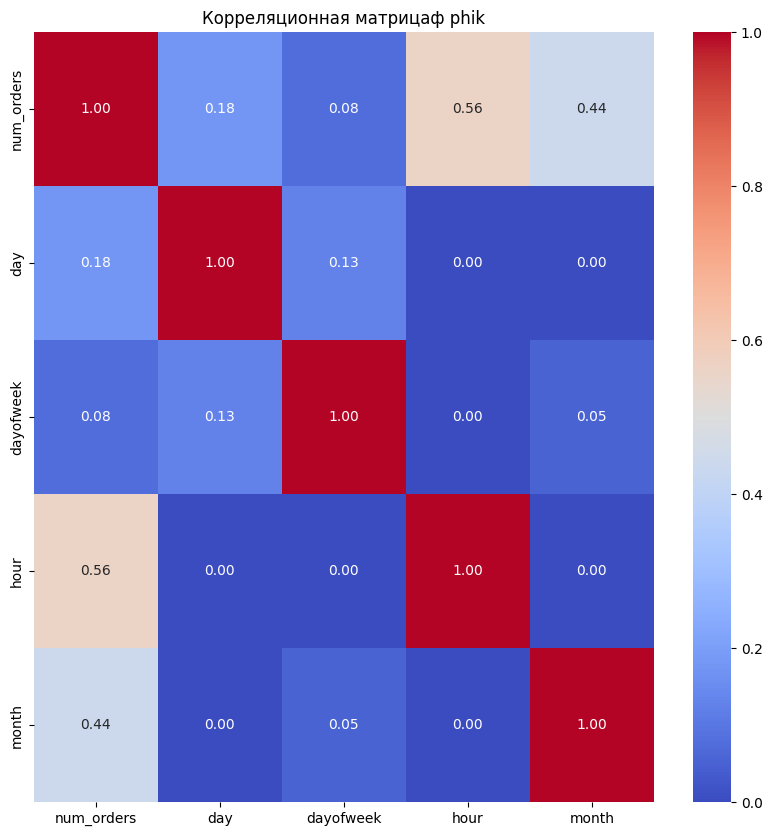

In [17]:
plt.figure(figsize=(10,10))
sns.heatmap(df.phik_matrix(interval_cols=df.select_dtypes(include=np.number)), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Корреляционная матрицаф phik')
plt.show();

Как видим, у всех признаков есть корреляци, что хорошо. Мультиколлинеарность отсутствует. Удалим эти столбцы, позже добавим в предобработчике.

In [18]:
df.drop(['day', 'dayofweek', 'hour', 'month'], axis=1, inplace=True)

Построим график автокорреляции. Сначала со сдвигом на сутки, на неделю (24 * 7 = 168) назад, затем на месяц (30 * 24 = 720).

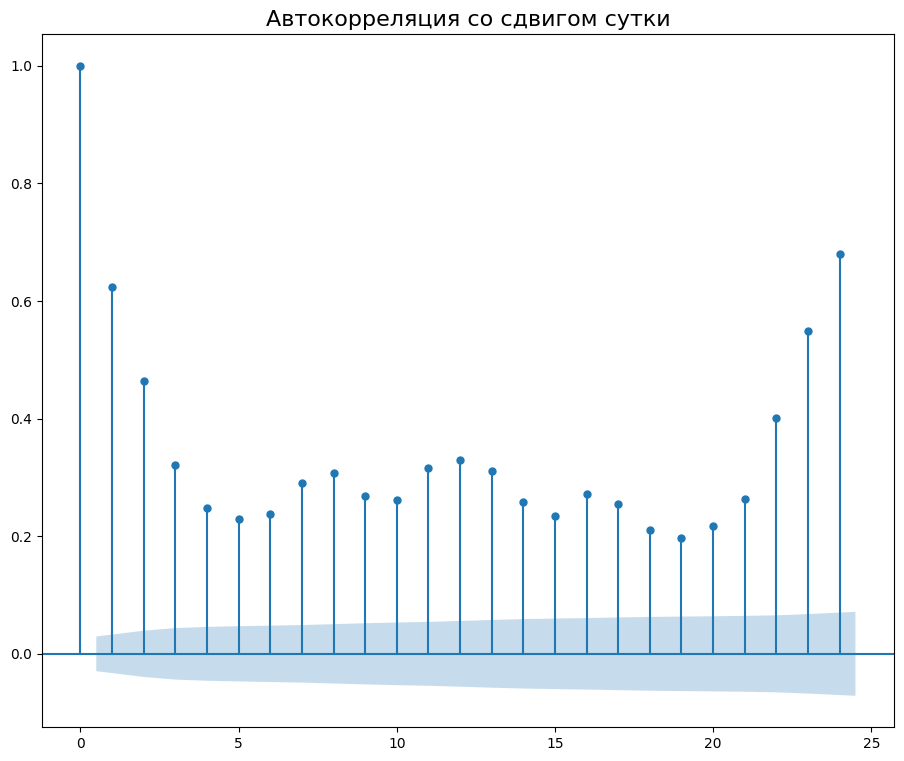

In [19]:
plot_acf(df, lags = 24)
 
plt.axis('tight')
plt.title('Автокорреляция со сдвигом сутки', fontsize=16)
plt.show()

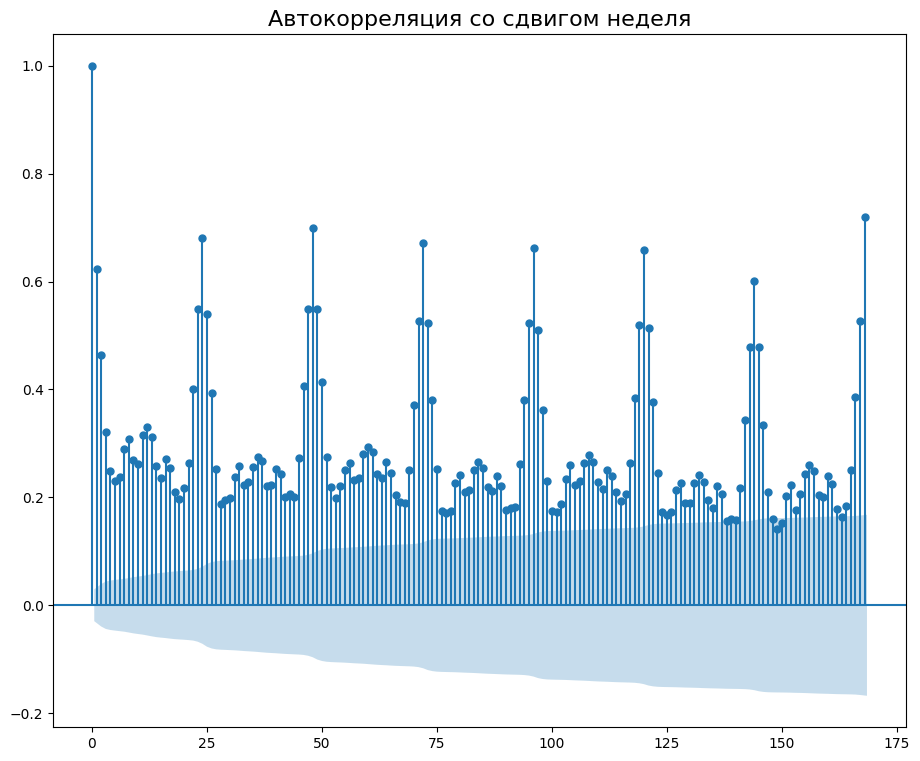

In [20]:
plot_acf(df, lags = 168)
 
plt.axis('tight')
plt.title('Автокорреляция со сдвигом неделя', fontsize=16)
plt.show()

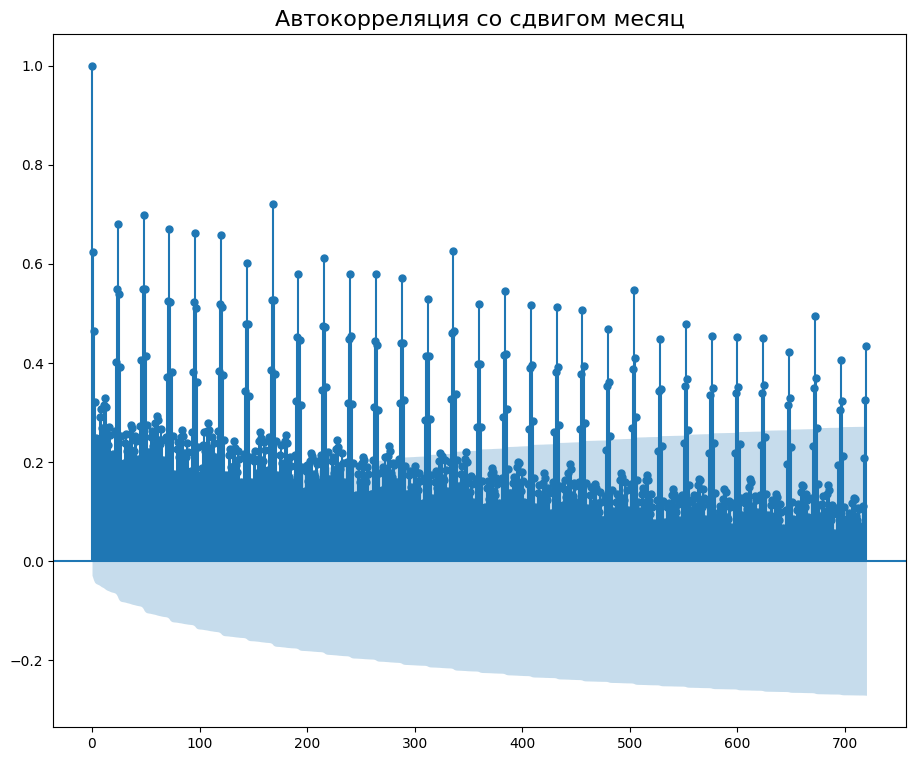

In [21]:
plot_acf(df, lags = 720)
 
plt.axis('tight')
plt.title('Автокорреляция со сдвигом месяц', fontsize=16)
plt.show()

Видим, что каждые сутки проявляется корреляция, потому что мы уже видели, что в ночные часы растет спрос. Посмотрим графики корреляции для скользящих среднего и std.

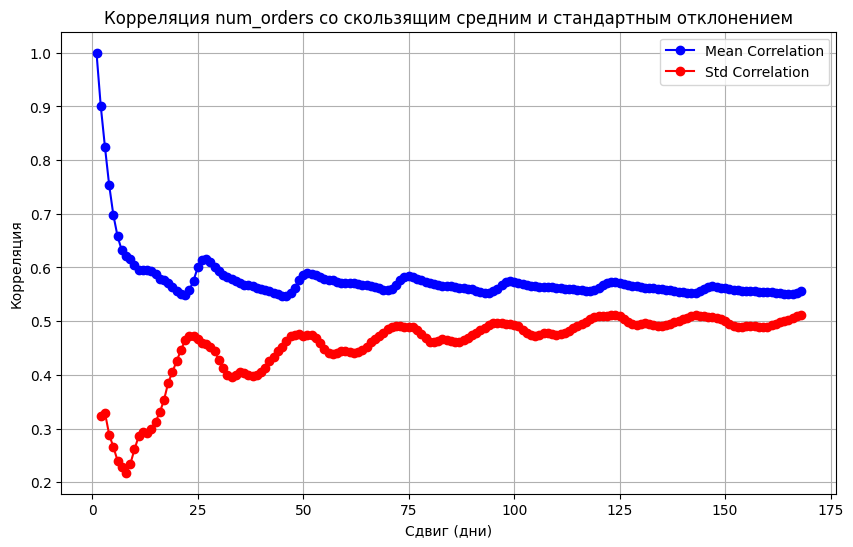

In [22]:
def calculate_correlations(data, max_shift):
    mean_correlations = []
    std_correlations = []
    for shift in range(1, max_shift + 1):
        rolling_mean = data['num_orders'].rolling(shift).mean()
        rolling_std = data['num_orders'].rolling(shift).std()
        mean_correlation = data['num_orders'].corr(rolling_mean)
        std_correlation = data['num_orders'].corr(rolling_std)
        mean_correlations.append((shift, mean_correlation))
        std_correlations.append((shift, std_correlation))
    return mean_correlations, std_correlations

max_shift = 168
mean_correlations, std_correlations = calculate_correlations(df, max_shift)

mean_corr_df = pd.DataFrame(mean_correlations, columns=['Shift', 'Correlation'])
std_corr_df = pd.DataFrame(std_correlations, columns=['Shift', 'Correlation'])

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(mean_corr_df['Shift'], mean_corr_df['Correlation'], marker='o', color='blue', label='Mean Correlation')
plt.plot(std_corr_df['Shift'], std_corr_df['Correlation'], marker='o', color='red', label='Std Correlation')
plt.title('Корреляция num_orders со скользящим средним и стандартным отклонением')
plt.xlabel('Сдвиг (дни)')
plt.ylabel('Корреляция')
plt.legend()
plt.grid(True)
plt.show()


## Вывод 

Были добавлены новые признаки с соответсующими корреляциями:

- day - 0.18
- dayofweek - 0.08
- hour - 0.56
- month - 0.44

Ещё раз было подтверждено, что каждые сутки в одно и то же время количество заказов примерно похоже. Это указывает на существование сильной суточной сезонности в данных. Анализ автокорреляционной функции также поддерживает этот вывод, показывая высокие значения автокорреляции на кратных суточным лагам. Это подтверждает, что временной ряд обладает выраженной повторяемостью и предсказуемыми паттернами в течение дня. Кроме того, были рассмотрены корреляции со скользящими средними и стандартным отклонением. ОТ стандартного отклонения нет смысла, потому что оно всегда ниже 0.5, при росте начинает к нему стремиться. От скользящего среднем больше смысла, но оно тоже начинает стремиться к 0.5 при росте, но до 25, оно может помочь в предсказании.

# Обучение моделей

Сначала посмотрим метрики на моделях, предсказывающих константой и предыдущим значением. Сначала разделим данные.

In [23]:
X = df.drop(['num_orders'], axis=1)
y = df['num_orders']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y, 
    test_size=0.1,
    shuffle=False,
    random_state=RANDOM_STATE
)

In [24]:
print('Среднее количество заказов на тренировочной выборке:', y_train.mean())
print('Метрика на тренировочной выборке при предсказании средним:', root_mean_squared_error(y_train, [y_train.mean()]*len(y_train)))

Среднее количество заказов на тренировочной выборке: 78.29063915450428
Метрика на тренировочной выборке при предсказании средним: 38.66694570860161


In [25]:
print('Метрика на тренировочной выборке при предсказании предыдущим значением:', root_mean_squared_error(y_train, y_train.shift(1).fillna(0)))

Метрика на тренировочной выборке при предсказании предыдущим значением: 36.19418980918945


Как видим, у первой модели метрика вышла немногим больше 38, значит, можно постараться добиться сильно меньше, чем 38. Метрика при сдвиге вышла даже подходящей, но это явно не лучший результат из возможных и не факт, что тестовая выборка с ее изменяющимся трендом покажет похожий результат, поэтому попробуем найти лучшую модель.

Попробуем действовать следующим образом: будем перебирать значение сдвига и окна скользящего среднего, чтобы найти лучшую метрику для моделей. Напишем функцию для добавления параметров. Из моделей будем пробовать линейную регрессию, XGBoost и LightGBM. Будем брать max_lag и rolling_mean_size равными 48, так как мы видели, что значения примерно повторяются каждые сутки.

In [26]:
def make_features(data, max_lag, rolling_mean_size):
    data_tr = data.copy()
    data_tr['month'] = data.index.month
    data_tr['day'] = data.index.day
    data_tr['hour'] = data.index.hour

    for lag in range(1, max_lag + 1):
        data_tr['lag_{}'.format(lag)] = data_tr['num_orders'].shift(lag)
    if rolling_mean_size != 0:
        data_tr['rolling_mean'] = data_tr['num_orders'].shift().rolling(rolling_mean_size).mean()

    return data_tr

def search(data, lag_range, roll_range, given_model):
    min_metric = float('inf')
    for lag in range(lag_range + 1):
        for window in range(roll_range + 1):
            data_temp = make_features(df, max_lag=lag, rolling_mean_size=window)
            train, test = train_test_split(data_temp, shuffle=False, test_size=0.1, random_state=RANDOM_STATE)
            train.dropna(inplace=True)
            train, val = train_test_split(train, shuffle=False, test_size=0.25, random_state=RANDOM_STATE)
    
            X_train, y_train = train.drop('num_orders', axis=1), train['num_orders']
            X_val, y_val = val.drop('num_orders', axis=1), val['num_orders']
            model = given_model
            model.fit(X_train, y_train)
            metric_train = root_mean_squared_error(model.predict(X_train), y_train)
            metric_val = root_mean_squared_error(model.predict(X_val), y_val)
            print(lag, window, metric_train, metric_val)
            if metric_val < min_metric:
                min_metric = metric_val
                best_lag = lag
                best_window = window
                best_model = model

    return best_lag, best_window, metric_train, metric_val

## Линейная регрессия

Начнем с модели линейной регрессии, переберем и посмотрим для нее параметры.

In [27]:
start_time = time.time()
lag_lin, window_lin, metric_train_lin, metric_val_lin = search(df, 48, 48, LinearRegression())  
end_time = time.time()
lin_time = end_time - start_time

0 0 32.003962557344295 41.769320159822804
0 1 28.126419786409187 37.66810511858746
0 2 28.8136712046942 38.62866886466738
0 3 29.769037921806 40.191167971823326
0 4 30.581208567809856 40.991429391825505
0 5 31.038775281134996 41.52234453929748
0 6 31.373772208548065 41.74817644666482
0 7 31.523594864793417 41.64499405155578
0 8 31.563545944752246 41.60696581262146
0 9 31.697566333048727 41.61272557199188
0 10 31.773120068782312 41.648730009973704
0 11 31.770638042912363 41.591495918261025
0 12 31.759427062712927 41.48501860105493
0 13 31.773801038993337 41.45339992831959
0 14 31.845124958329755 41.54412312523846
0 15 31.92178898763948 41.62773162591008
0 16 31.951131898051333 41.65839734657314
0 17 31.99109157029908 41.72149542737463
0 18 32.01762861290685 41.85506626290834
0 19 32.01130592649235 41.95298824296238
0 20 31.984490363616022 42.05947631180125
0 21 31.97602953339323 42.091589909188
0 22 32.011596650679856 42.061199071759056
0 23 32.01506188920287 41.780806290934265
0 24 31.

In [28]:
print('Линейная модель:')
print('Lag:', lag_lin)
print('Размер окна скользящего среднего:', window_lin)
print('RMSE на тренировочной:', metric_train_lin)
print('RMSE на валидационной:', metric_val_lin)
print('Время обучения и подбора:', lin_time)

Линейная модель:
Lag: 48
Размер окна скользящего среднего: 45
RMSE на тренировочной: 21.15352058206298
RMSE на валидационной: 29.548167767561438
Время обучения и подбора: 55.274309158325195


Полученная метрика намного лучше, чем констатные.

## LigthGBM

Попробуем градиентные модели.

In [29]:
start_time = time.time()
lag_gbm, window_gbm, metric_train_gbm, metric_val_gbm = search(df, 48, 48, LGBMRegressor(verbose=-1, random_state=RANDOM_STATE))  
end_time = time.time()
gbm_time = end_time - start_time

0 0 17.305045270008108 31.361951293349996
0 1 16.084879198909746 31.502208769739063
0 2 15.742264024004019 30.84183396334717
0 3 15.514810206075236 30.02582831056983
0 4 15.542887927908309 30.70285587551911
0 5 15.394604843221549 31.026565201608314
0 6 15.58570126229353 30.904217503337613
0 7 15.541879944644384 30.516008919740194
0 8 15.52171469153865 30.408610944685865
0 9 15.432558483880221 30.310751472316653
0 10 15.516559021980823 29.944578674373535
0 11 15.530990583245837 30.625771061990772
0 12 15.561906947362026 30.22388458276672
0 13 15.702636836498533 30.167161718878067
0 14 15.822140475964108 30.410992775296474
0 15 15.699984129090105 30.928997946161854
0 16 15.982677071306298 30.434917092558997
0 17 15.956759962407908 31.308276273145946
0 18 15.879618856291938 30.82900961728968
0 19 16.092802314063587 32.087978442746504
0 20 15.95510398279816 32.409175671518454
0 21 15.97475784722274 34.230577036126874
0 22 16.035497826299125 34.46181873330127
0 23 16.077111217974085 34.2843

In [30]:
print('CatBoost модель:')
print('Lag:', lag_gbm)
print('Размер окна скользящего среднего:', window_gbm)
print('RMSE на тренировочной:', metric_train_gbm)
print('RMSE на валидационной:', metric_val_gbm)
print('Время обучения и подбора:', gbm_time)

CatBoost модель:
Lag: 48
Размер окна скользящего среднего: 7
RMSE на тренировочной: 8.530026921012297
RMSE на валидационной: 29.624143328755377
Время обучения и подбора: 300.9109408855438


## XGB

In [31]:
start_time = time.time()
lag_xgb, window_xgb, metric_train_xgb, metric_val_xgb = search(df, 48, 48, XGBRegressor(random_state=RANDOM_STATE))  
end_time = time.time()
xgb_time = end_time - start_time

0 0 11.205428615373348 34.65725081575948
0 1 9.40981314537991 33.7177265197657
0 2 8.70850905329386 35.595300562967886
0 3 8.83296457682623 33.082874236869635
0 4 9.177111073615244 33.422120414767775
0 5 8.876264972742735 36.50938856687409
0 6 9.057388086016593 32.007343867777486
0 7 9.230068030921846 32.93718521275781
0 8 8.873417463844904 33.354348008958745
0 9 9.040535841901349 33.60078266309392
0 10 8.928550340939822 32.130591309166114
0 11 8.89339329799874 31.583249436549874
0 12 8.699588169850326 33.67840041594361
0 13 9.081435680931932 32.894055349461574
0 14 9.13231135960261 33.72737271115234
0 15 8.626479115745884 34.70219135922131
0 16 9.073939465178036 34.60963255722104
0 17 8.931704516218732 37.22720675154948
0 18 9.087215961591303 33.700128215373205
0 19 8.775382003052906 36.88137234158525
0 20 8.88290147199991 38.17236970027836
0 21 9.409791219389486 40.36580621183356
0 22 9.287916231090536 38.0103121524655
0 23 9.110772927725243 37.46109955298109
0 24 9.579987582047428 4

In [32]:
print('XGB модель:')
print('Lag:', lag_xgb)
print('Размер окна скользящего среднего:', window_xgb)
print('RMSE на тренировочной:', metric_train_xgb)
print('RMSE на валидационной:', metric_val_xgb)
print('Время обучения и подбора:', xgb_time)

XGB модель:
Lag: 9
Размер окна скользящего среднего: 16
RMSE на тренировочной: 3.402744908257232
RMSE на валидационной: 31.0253327197207
Время обучения и подбора: 738.6848845481873


## Вывод

Модели обучены, посмотрим результат в таблице.

In [33]:
ml_results = pd.DataFrame([
    ['Базовая модель 1*', root_mean_squared_error(y_train, [y_train.mean()]*len(y_train)), '-', '-', '-', '-'],
    ['Базовая модель 2*', root_mean_squared_error(y_train, y_train.shift(1).fillna(0)), '-', '-', '-', '-'],
    ['Линейная регрессия', metric_train_lin, metric_val_lin, lag_lin, window_lin, lin_time],
    ['LigthGBM', metric_train_gbm, metric_val_gbm, lag_gbm, window_gbm, gbm_time],
    ['XGB', metric_train_xgb, metric_val_xgb, lag_xgb, window_xgb, xgb_time]
],
columns = ['Модель', 'RMSE на тренировочной', 'RMSE на валидационной', 'Смещение (лаг)', 'Размер скользящего окна', 'Время обучения'])
ml_results

,Модель,RMSE на тренировочной,RMSE на валидационной,Смещение (лаг),Размер скользящего окна,Время обучения
0,Базовая модель 1*,38.666946,-,-,-,-
1,Базовая модель 2*,36.194190,-,-,-,-
2,Линейная регрессия,21.153521,29.548168,48,45,55.274309
3,LigthGBM,8.530027,29.624143,48,7,300.910941
4,XGB,3.402745,31.025333,9,16,738.684885


Как видим, чем дольше обучается модель, тем лучше результат на тренировочной. Лучший результат на тренировочной показывает XGBoost, но она показывает худший результат на валидации. Лучший результат на валидации у LightGBM и у нее средний результат на тренировочной, поэтому возьмём её и посмотрим результат на тестовой.

In [34]:
train, test = train_test_split(make_features(df, lag_gbm, window_gbm), shuffle=False, test_size=0.1, random_state=RANDOM_STATE)
X_train, y_train = train.drop('num_orders', axis=1), train['num_orders']

gbm_model = LGBMRegressor(verbose=-1, random_state=RANDOM_STATE)
gbm_model.fit(X_train, y_train)

X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

print('Результат LightGBM на тестовой выборке:', root_mean_squared_error(gbm_model.predict(X_test), y_test))

Результат LightGBM на тестовой выборке: 39.821917733051436


Как видим, метрика вышла подходящей под условие.

# Вывод 


Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах с целью привлечения большего числа водителей в периоды пиковой нагрузки. Для этого необходимо спрогнозировать количество заказов такси на следующий час.

В ходе исследовательского анализа данных были изучены динамика спроса на такси, тренды, сезонные колебания и шум. Графики скользящего среднего и стандартного отклонения показали средний уровень спроса и его изменчивость. Анализ выявил рост спроса с марта по август, что указывает на сезонные изменения или увеличивающийся интерес к такси в теплые месяцы. Ночная активность также оказалась пиковой, с наибольшим спросом к полуночи.

Хотя по дням недели четких закономерностей в изменении спроса не выявлено, было подтверждено, что спрос на такси демонстрирует суточную сезонность, что подтверждают автокорреляционная функция и анализ повторяемости паттернов в течение дня.

Для прогноза числа заказов на следующий час были обучены три модели: линейная регрессия, XGBoost и LightGBM. Лучшие результаты на тренировочной выборке показала модель XGBoost, но она оказалась наименее эффективной на валидации. Модель LightGBM показала лучшие результаты на валидационной выборке и средние на тренировочной, поэтому она была выбрана для окончательного тестирования.

Таким образом, проведенный анализ и выбранная модель LightGBM позволят компании «Чётенькое такси» эффективно прогнозировать спрос на такси и привлекать водителей в периоды пиковой нагрузки.